# Compute input datasets for sedflux generation from model output

Generate a set of files for each of the following groups:

- POC-FLUX: ['POC_FLUX_IN']
- Velocity: ['UVEL', 'VVEL']

Steps:
1. Produce files on a set of source grids
1. Optionally generate on a set of destination grids


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import shutil
from glob import glob

from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import esmlab
import esmlab_regrid

import pop_tools

import util

In [3]:
clobber = False

## Build and test horizontal regridding

### Generate SCRIP grid files for each of the supported grids.

Ideally, a regridding workflow would support this in situ.

In [4]:
grids = {}
for grid_name in util.POP_grids:
    grids[grid_name] = pop_tools.get_grid(grid_name) 
for grid_name in ["MOM_tx0.66v1", "MOM_tx2_3v2"]:
    grids[grid_name] = util.get_MOM_grid(grid_name) 


# src_grid = "POP_tx0.1v3"
# dst_grid = "MOM_tx0.66v1"
# grids = {
#     src_grid: pop_tools.get_grid(src_grid),
#     dst_grid: util.get_MOM_grid(dst_grid)
# }

dst_grid = "MOM_tx2_3v2"
grids

/glade/work/mlevy/miniconda3/envs/forcing-Fe-sedflux/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


{'POP_tx0.1v3': <xarray.Dataset>
 Dimensions:      (nlat: 2400, nlon: 3600, z_t: 62, z_w: 62, z_w_bot: 62)
 Coordinates:
   * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
   * z_w          (z_w) float64 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
   * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
 Dimensions without coordinates: nlat, nlon
 Data variables: (12/13)
     TLAT         (nlat, nlon) float64 -78.47 -78.47 -78.47 ... 62.34 62.34 62.34
     TLONG        (nlat, nlon) float64 250.0 250.2 250.2 ... 250.0 250.0 250.0
     ULAT         (nlat, nlon) float64 -78.45 -78.45 -78.45 ... 62.34 62.34 62.34
     ULONG        (nlat, nlon) float64 -109.9 -109.8 -109.7 ... -110.0 -110.0
     DXT          (nlat, nlon) float64 1.116e+05 1.122e+05 ... 2.042e+03 927.1
     DYT          (nlat, nlon) float64 4.699e+05 4.699e+05 ... 1.664e+03 794.8
     ...           ...
     DYU          (nlat, nlon) float64 4.699e+05 4.699e+05 ... 2.351e+0

### Construct weight file names and ensure they are present

`esmlab_regrid` should support generating weight files, but I am getting and ESMF error about PIO not being available. Probably this requires some `module loads` before launching...but that's not acceptable if that's the case, there should be no dependencies outside of the `conda` environment.

As a workaround, I wrote [esmf_gen_weights_pop2pop.pbs](esmf_gen_weights_pop2pop.pbs) and run this on the batch nodes.

In [5]:
method = 'conservative'
get_key = lambda src, dst: f'{src}_to_{dst}_{method}'    

weight_files = {}
for src, dst in product(grids.keys(), grids.keys()): 
    if src == dst: continue
    if src.startswith("MOM"): continue
    if src == "POP_gx3v7" and dst.startswith("MOM"): continue
    key = get_key(src, dst)
    value = util.file_name_weight(src, dst, method)
    weight_files[key] = value
    
missing = {k: f for k, f in weight_files.items() if not os.path.exists(f)}
if missing:
    missing_some = True
    print(f'missing weight files:\n{list(missing.keys())}\n\nrun the following:\nqsub < esmf_gen_weights_POP_to_POP.pbs\n')
else:
    print('all weight files are present')

all weight files are present


### Construct dictionary of horizontal regridding operators

In [6]:
regrid_operator = {}
for src_grid, dst_grid in product(grids.keys(), grids.keys()): 
    if src_grid == dst_grid: continue
    if src_grid.startswith("MOM"): continue
    if src_grid == "POP_gx3v7" and dst_grid.startswith("MOM"): continue
    key = get_key(src_grid, dst_grid)
    regrid_operator[key] = esmlab_regrid.regridder(
        name_grid_src=src_grid, 
        name_grid_dst=dst_grid, 
        method=method, 
        overwrite_existing=False
    )

"Test" regridding with `TAREA` field from the grid. Here I am just aiming to pass a sniff test: does the remapped field look right.

What's a better way to test this? The differing land-mask will mean integrals don't match....


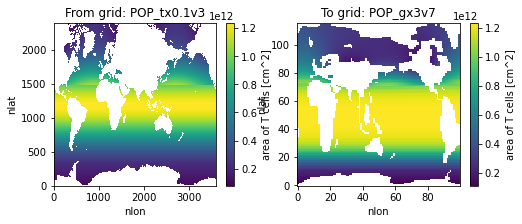

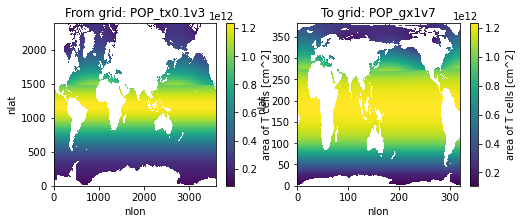

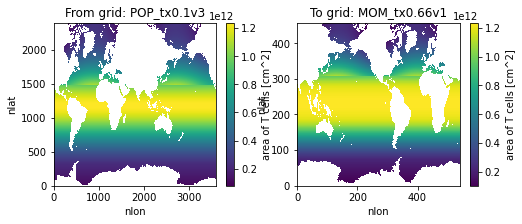

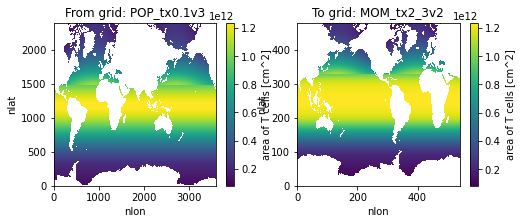

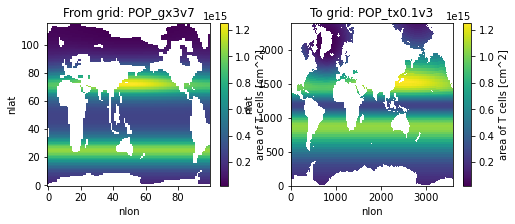

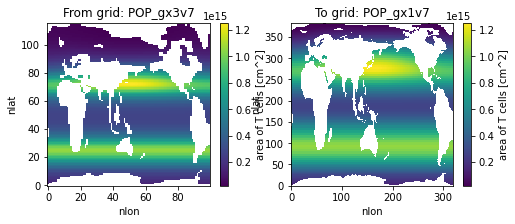

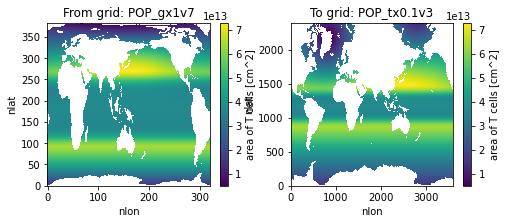

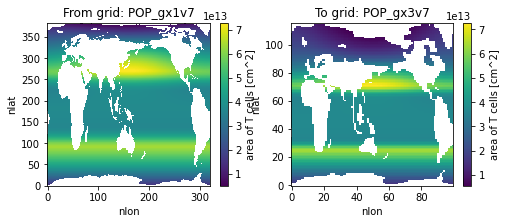

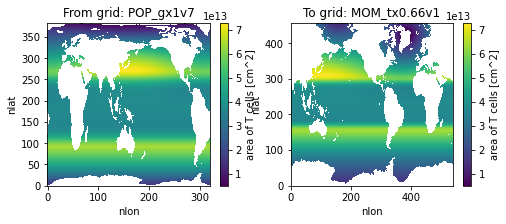

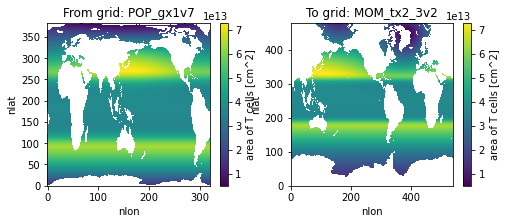

In [7]:
for src_grid, dst_grid in product(grids.keys(), grids.keys()): 
    if src_grid == dst_grid: continue
    if src_grid.startswith("MOM"): continue
    if src_grid == "POP_gx3v7" and dst_grid.startswith("MOM"): continue
    key = get_key(src_grid, dst_grid)

    da_src = grids[src_grid].TAREA.where(grids[src_grid].KMT > 0)
    
    da_dst = regrid_operator[key](
        da_src,
        renormalize=True, 
        apply_mask=True
    )
    
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(1, 2, 1)
    da_src.plot()
    ax.set_title(f'From grid: {src_grid}')
    ax = fig.add_subplot(1, 2, 2)
    da_dst.plot()
    ax.set_title(f'To grid: {dst_grid}')

### Define vertical interpolation

Generate pseudo-data for each grid, a DataArray with 0:km-1 in each column

In [8]:
da_test_src = {}
for src_grid, grid in grids.items():
    nk, nj, ni = len(grid.z_t), len(grid.nlat), len(grid.nlon)
    k = xr.DataArray(np.arange(0, nk), dims=('z_t'), coords={'z_t': grids[src_grid].z_t})
    ones = xr.DataArray(
        np.ones((nk, nj, ni)), 
        dims=('z_t', 'nlat', 'nlon'), 
        coords={'z_t': grids[src_grid].z_t}
    )
    
    da_test_src[src_grid] = k * ones 

Test vertical remappiong function

In [9]:
# unit test: apply remapping and confirm that values match
da_dst = dict()

for src_grid, dst_grid in product(grids.keys(), grids.keys()): 
    if src_grid == dst_grid: continue
    if src_grid.startswith("MOM"): continue
    if src_grid == "POP_gx3v7" and dst_grid.startswith("MOM"): continue
    key = f"{src_grid}_to_{dst_grid}"

    da_src = da_test_src[src_grid]

    if not dst_grid.startswith("MOM"):
        da_dst[key] = util.remap_z_t(
            da_src, 
            src_grid,
            dst_grid,
        )

        nk_src, nk_dst = len(da_src.z_t), len(da_dst[key].z_t)
        if nk_src < nk_dst:
            assert (da_src[:, 0, 0] == da_dst[key][:nk_src, 0, 0]).all()
            assert (da_src[-1, 0, 0] == da_dst[key][-(nk_dst-nk_src):, 0, 0]).all()        

        elif nk_src > nk_dst:
            assert (da_src[:nk_dst, 0, 0] == da_dst[key][:, 0, 0]).all()        

        else:
            assert (da_dst[key][:, 0, 0] == da_src[:, 0, 0]).all()
    else:
        da_dst[key] = util.reintegrate_z_t_to_MOM(da_src, src_grid)
        print(da_dst[key])



<xarray.DataArray (z_t: 103, nlat: 2400, nlon: 3600)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [

In [10]:
da_test_src[src_grid]

<xarray.DataArray (z_t: 103, nlat: 480, nlon: 540)>
array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  1.,   1.,   1., ...,   1.,   1.,   1.],
        [  1.,   1.,   1., ...,   1.,   1.,   1.],
        [  1.,   1.,   1., ...,   1.,   1.,   1.],
        ...,
        [  1.,   1.,   1., ...,   1.,   1.,   1.],
        [  1.,   1.,   1., ...,   1.,   1.,   1.],
        [  1.,   1.,   1., ...,   1.,   1.,   1.]],

       [[  2.,   2.,   2., ...,   2.,   2.,   2.],
        [  2.,   2.,   2., ...,   2.,   2.,   2.],
        [  2.,   2.,   2., ...,   2.,   2.,   2.],
        ...,
...
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        ...,
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.]],

       [[102., 102., 102., ..., 102., 102., 102.],
        [102., 102., 102., ..., 102., 102., 102.],
        [102., 102., 102., ..., 102., 102., 102.],
        ...,
        [102., 102., 102., ..., 102., 102., 102.],
        [102., 102., 102., ..., 102., 102., 102.],
        [102., 102., 102., ..., 102., 102., 102.]]])
Coordinates:
  * z_t      (z_t) float64 250.0 750.0 1.25e+03 ... 5.45e+05 5.625e+05 5.875e+05
Dimensions without coordinates: nlat, nlon

Define a fill procedure based on `pop_tools`. 

First, define a function to generate a 3D mask.

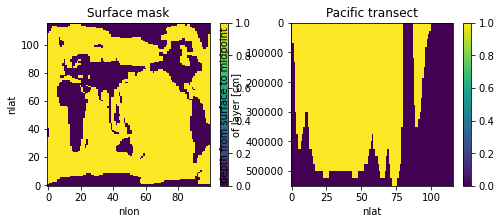

In [11]:
def get_mask(ds_pop):
    required_vars = ['z_t', 'KMT']
    missing_vars = set(required_vars) - set(ds_pop.variables)
    if missing_vars:
        raise ValueError(f'missing required vars:\n {missing_vars}')
    
    nk, nj, ni = len(ds_pop.z_t), len(ds_pop.nlat), len(ds_pop.nlon)

    # make 3D array of 0:km
    zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
    ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
    ZERO_TO_KM = (zero_to_km * ONES_3d)

    # mask out cells where k is below KMT
    MASK = ZERO_TO_KM.where(ZERO_TO_KM < ds_pop.KMT)
    MASK = xr.where(MASK.notnull(), True, False)

    return MASK.assign_coords({'z_t': ds_pop.z_t})

MASK = get_mask(grids['POP_gx3v7'])

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 2, 1)
MASK.isel(z_t=0).plot()
h = plt.title('Surface mask')

ax = fig.add_subplot(1, 2, 2)
MASK.isel(nlon=65).plot(yincrease=False)
h = plt.title('Pacific transect')

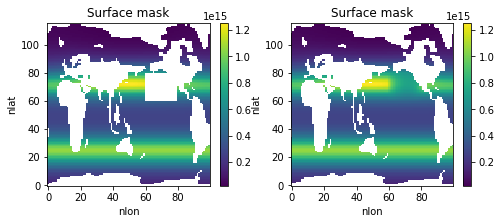

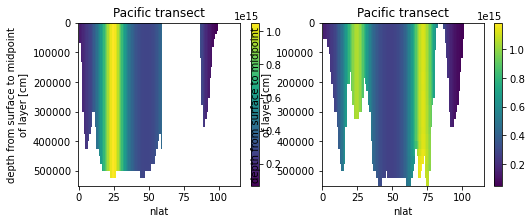

In [12]:
def fill_unmapped_points(da, grid_name):
    """fill unmapped points"""
    
    ds_grid = grids[grid_name]
    MASK = get_mask(ds_grid)
    ltripole = (ds_grid.type == 'tripole')
    
    da_fill = pop_tools.lateral_fill(da.copy(), MASK, ltripole=ltripole)
    
    # propagate values down to fill vertically, if necessary
    unfilled = da_fill.isnull() & (MASK == 1.) 
    if not unfilled.any():
        return da_fill
    
    nk = len(da_fill.z_t)
    for k in range(1, nk):
        da_fill[k, :, :] = xr.where(
            unfilled[k, :, :], 
            da_fill[k-1, :, :], 
            da_fill[k, :, :]
        )    
    return da_fill


# Check to see if it works
grid = 'POP_gx3v7'
test_field = (get_mask(grids[grid]) * grids[grid].TAREA).where(get_mask(grids[grid]) > 0)
test_field[:, 60:80, 60:80] = np.nan
test_field_fill = fill_unmapped_points(test_field, grid)

fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 2, 1)
test_field.isel(z_t=0).plot()
h = plt.title('Surface mask')

ax = fig.add_subplot(1, 2, 2)
test_field_fill.isel(z_t=0).plot()
h = plt.title('Surface mask')


fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 2, 1)
test_field.isel(nlon=65).plot(yincrease=False)
h = plt.title('Pacific transect')
ax = fig.add_subplot(1, 2, 2)
test_field_fill.isel(nlon=60).plot(yincrease=False)
h = plt.title('Pacific transect')

In [13]:
def ugrid_to_tgrid(arr_ugrid):
    """
    Interpolates values at U points on a B grid to T points.
    """
    with xr.set_options(keep_attrs=True):
        return 0.25 * (
            arr_ugrid +  # j, i
            arr_ugrid.roll(nlat=1, roll_coords=False) + # j-1, i
            arr_ugrid.roll(nlon=1, roll_coords=False) + # j, i-1
            arr_ugrid.roll(nlat=1, nlon=1, roll_coords=False) #j-1, i-1
        )

## Get model data and generate zarr archives 

In [14]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster()
cluster.scale(36)
cluster

In [15]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mlevy/MARBL_MOM/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mlevy/MARBL_MOM/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:41473,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mlevy/MARBL_MOM/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [17]:
def ds_mean_time(ds, variables):
    """Compute the temporal mean of a dataset
       using weights computed from `time_bound`.
    """
    time_weights = ds.time_bound.diff('d2').squeeze()
    time_total = time_weights.sum()
    wgt = time_weights / time_total
    np.testing.assert_allclose(wgt.sum(), 1.0, rtol=1e-7)

    with xr.set_options(keep_attrs=True):
        return (ds[variables] * wgt).sum('time')

#### empty markdown?

In [18]:
%%bash
pth=/glade/campaign/cesm/development/omwg
case=g.e20.G.TL319_t13.control.001_hfreq
pth=${pth}/${case}/ocn/hist/mavg
sc=/glade/scratch/mclong/campaign-mirror/${case}/ocn/hist/mavg

# cp -v ${pth}/${case}.pop.h.004?-??.nc ${sc}

In [19]:
dsets = dict()

grid_vars = ['TAREA', 'KMT', 'TLONG', 'TLAT', 'ULONG', 'ULAT', 'z_t'] #, 'time', 'time_bound']

def get_data(src_grid, variables):
    """return a time-mean dataset"""
    
    if src_grid == 'POP_gx1v7':
        
        case = 'b.e21.B1850.f09_g17.CMIP6-piControl.001'
        droot = f'/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/{case}'
        droot = f'{droot}/ocn/proc/tseries/month_1'
        datestr = '060001-069912'

        ds_grid = pop_tools.get_grid('POP_gx1v7')

        ds = xr.Dataset()
        input_files = []
        for v in variables:
            files = f'{droot}/{case}.pop.h.{v}.{datestr}.nc'
            input_files += ','.join(files)+'; '
            dsv = xr.open_dataset(
                files, 
                decode_times=False,
                decode_coords=False,
                chunks={'time': 24, 'z_t': 20},
            )
            ds = xr.merge((ds, dsv))

        with util.timer('computing time mean'):
            ds = ds_mean_time(ds, variables).drop('z_t').compute()

    elif src_grid == 'POP_tx0.1v3':
       
        case = 'g.e20.G.TL319_t13.control.001_hfreq'        
        #droot = '/glade/campaign/cesm/development/omwg'        
        droot = '/glade/scratch/mclong/campaign-mirror'
        droot = f'{droot}/{case}/ocn/hist/mavg'

        ds_grid = pop_tools.get_grid('POP_tx0.1v3')

        years = np.arange(50, 60, 1)

        print('computing each annual mean')    
        ds_sum = xr.Dataset()
        n = 0
        input_files = []
        for y in years:
            files = sorted(glob(f'{droot}/{case}.pop.h.{y:04d}-??.nc'))        
            if len(files) != 12:
                raise ValueError('expected 12 files')                
            
            input_files.extend(files)
            
            print(f'averaging {len(files)} files')
            with util.timer(f'year: {y:04d}'):                            
                ds = xr.open_mfdataset(
                    files, 
                    combine='nested', 
                    concat_dim='time',
                    chunks={'time': 1, 'nlon': 900, 'nlat': 600},
                    decode_times=False,
                    decode_coords=False,
                )
                ds = ds_mean_time(ds, variables).drop('z_t').compute()

                if n == 0:
                    ds_sum = ds
                else:
                    ds_sum = ds_sum + ds
                n += 1

        with util.timer('computing long-term mean'):
            ds = ds_sum / n

    else:
        raise ValueError(f'unknown grid: {grid}')
        
    ds.attrs['input_files'] = ','.join(input_files)
    
    return xr.merge((ds, ds_grid[grid_vars]))

In [20]:
var_groups = dict(
    poc_flux=['POC_FLUX_IN'],
    velocity=['UVEL', 'VVEL'],
)

        
def proc_var_group(var_group, src_grid, dst_grid=None):
    """Generate output dataset    
    """

    if dst_grid is None:
        dst_grid = src_grid

    variables = var_groups[var_group]
    key = f'{src_grid}-{var_group}'
       
    # get the input dataset
    if key in dsets:
        print('cached dataset')               
        ds_src = dsets[key]
        
    else:
        print('generating dataset from files')       
        ds_src = get_data(src_grid, variables)
        
        # put UVEL and VVEL on T-Grid
        if var_group == 'velocity':
            for v in variables:
                ds_src[v] = ugrid_to_tgrid(ds_src[v])

        dsets[key] = ds_src           
       
    # return dataset, performing regridding if necesssary
    if src_grid == dst_grid:
        return ds_src
    
    else:       
        ds_dst = xr.Dataset()

        for v in variables:
            # perform lateral regridding
            key = get_key(src_grid, dst_grid)
            da_dst = regrid_operator[key](
                ds_src[v], 
                renormalize=True, 
                apply_mask=True
            )
            
            # perform vertical regridding
            if not dst_grid.startswith("MOM"):
                da_dst = util.remap_z_t(da_dst, src_grid, dst_grid)
            else:
                da_dst = util.reintegrate_z_t_to_MOM(da_dst, src_grid)
            
            # fill missing values left on dst_grid
            da_dst = fill_unmapped_points(da_dst, dst_grid)
            
            # copy DataArray to outgoing Dataset
            ds_dst[v] = da_dst
            
        return ds_dst

In [21]:
# dst_grid = 'MOM_tx0.66v1'
dst_grid = 'MOM_tx2_3v2'

In [22]:
var_group_grids = dict(
    poc_flux=[
        ('POP_gx1v7', dst_grid), 
        # ('POP_gx1v7', 'MOM_tx0.66v1'), 
    ],
    velocity=[
        ('POP_gx1v7', dst_grid), 
        # ('POP_gx1v7', 'MOM_tx0.66v1'), 
#         ('POP_tx0.1v3', 'MOM_tx0.66v1'),
    ],
)

for var_group, src_dst_list in var_group_grids.items():
    for src_grid, dst_grid in src_dst_list:
        print('-'*80)
        print(f'{var_group}: {src_grid} --> {dst_grid}')
        
        file_out = f'{util.dirwork}/{var_group}.{src_grid}_to_{dst_grid}.zarr'
        
        if clobber and os.path.exists(file_out):
            shutil.rmtree(file_out)            
        
        if os.path.exists(file_out):
            print(f'existing file: {file_out}')
            #dso = xr.open_zarr(file_out)
        else: 
            dso = proc_var_group(var_group, src_grid, dst_grid)
            dso.to_zarr(file_out)
            dso.info()
        print()            

--------------------------------------------------------------------------------
poc_flux: POP_gx1v7 --> MOM_tx2_3v2
generating dataset from files
[computing time mean]: 134.90 sec
xarray.Dataset {
dimensions:
	z_t = 103 ;
	nlat = 480 ;
	nlon = 540 ;

variables:
	float64 z_t(z_t) ;
		z_t:units = cm ;
	float64 POC_FLUX_IN(z_t, nlat, nlon) ;
		POC_FLUX_IN:long_name = POC Flux into Cell ;
		POC_FLUX_IN:units = mmol/m^3 cm/s ;
		POC_FLUX_IN:coordinates = TLONG TLAT z_t time ;
		POC_FLUX_IN:grid_loc = 3111 ;
		POC_FLUX_IN:cell_methods = time: mean ;
		POC_FLUX_IN:regrid_method = conservative ;
		POC_FLUX_IN:history = 
2023-10-16 13:56:56.681266 esmlab.regrid <regrid>  ;

// global attributes:
}
--------------------------------------------------------------------------------
velocity: POP_gx1v7 --> MOM_tx2_3v2
generating dataset from files
[computing time mean]: 105.84 sec
xarray.Dataset {
dimensions:
	z_t = 103 ;
	nlat = 480 ;
	nlon = 540 ;

variables:
	float64 z_t(z_t) ;
		z_t:units = cm ;

In [23]:
client.close()
cluster.close()

### Some POC conservation tests

In [24]:
def compute_lateral_mean_vertical_sum_POC(ds, area):
    return (ds["POC_FLUX_IN"]*ds[area]).sum().data/1e4

In [25]:
dso = proc_var_group("poc_flux", src_grid, dst_grid)
ds_mom_grid = util.get_MOM_grid(dst_grid)
dso["TAREA"] = ds_mom_grid["TAREA"]

cached dataset


In [26]:
pop_POC_sum = compute_lateral_mean_vertical_sum_POC(dsets["POP_gx1v7-poc_flux"], "TAREA")
pop_POC_sum

47340701001320.66

In [27]:
mom_POC_sum = compute_lateral_mean_vertical_sum_POC(dso, "TAREA")
mom_POC_sum

47359153460062.08

In [28]:
(pop_POC_sum - mom_POC_sum) / pop_POC_sum

-0.00038978000644534415